# Crypto Currency Analysis

https://anilpai.medium.com/currency-arbitrage-using-bellman-ford-algorithm-8938dcea56ea

## Installations and Imports

In [ ]:
import sys
if "google.colab" in sys.modules:
    !pip install -q ccxt
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

     |████████████████████████████████| 2.5 MB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 52.9 MB/s 
     |████████████████████████████████| 1.1 MB 49.1 MB/s 
     |████████████████████████████████| 271 kB 54.1 MB/s 
     |████████████████████████████████| 3.6 MB 53.1 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 291 kB 50.4 MB/s 
     |████████████████████████████████| 144 kB 53.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
installing pyomo . pyomo installed
installing and testing solvers ...
.. glpk installed
.. ipopt
.. gecode
.. couenne
.. bonmin
.. gurobi_direct installed
.. cbc installed
install

In [ ]:
import ccxt
import pandas as pd
import numpy as np
import os
import pyomo.environ as pyo

from time import time
from timeit import default_timer as timer
from graphviz import Digraph

## Select an exchange and load available symbols

In [ ]:
# set the exchange ... careful of generators here
exchange = ccxt.binanceus()
markets = exchange.load_markets()
symbols = exchange.symbols
exch = str(exchange)

## Interpreting Trading Symbols as Directed Graphs

Each market symbol on an exchange describes currency transactions that we'll characterize with a source/destination pair. The exchange symbol

$$SRC/DST$$

describes two potential transactions:

* $SRC \rightarrow DST$ converts one unit $SRC$ on that exchange to multiple units of $DST$ equal to 'bid' price on that exchange, and
* $DST \rightarrow SRC$ converts one unit of $DST$ on to multiple units of $SRC$ at the inverse of the 'ask' price.

The transactions are specific to the associated exchange.

Here we represent the transcations using nodes and edges from graph theory. Each 

From the sources and destinations we create a set of nodes that will be indexed by (EXCH, CURR).



In [ ]:
# split symbols into SRC -> DST arcs and create list of currencies

# lists of all currencies and trades that appear in symbols
src_dst_pairs = [symbol.split('/') for symbol in symbols]
currencies = sorted(list(set([currency for src_dst in src_dst_pairs for currency in src_dst])))

# count times each currency as a src and a dst 
src_count = pd.Series({currency: sum(1 for src, dst in src_dst_pairs if currency==src)  for currency in currencies})
dst_count = pd.Series({currency: sum(1 for src, dst in src_dst_pairs if currency==dst)  for currency in currencies})

# which currencies appear as SRC
print("\nCurrencies appearing one more times as SRC")
print(src_count[src_count >= 1])

# which currencies appear as DST
print("\nCurrencies appearing one more times as DST")
print(dst_count[dst_count >= 1])


Currencies appearing one more times as SRC
1INCH    2
AAVE     2
ADA      4
ALGO     3
AMP      1
        ..
YFI      2
ZEC      2
ZEN      2
ZIL      2
ZRX      2
Length: 86, dtype: int64

Currencies appearing one more times as DST
BTC     19
BUSD    21
USD     83
USDC     2
USDT    69
dtype: int64


We seek ways of restricting the graph to the most traded or most liquid currencies. Here we identify the "base" currencies as those appearing in the destination list, and keep source currencies that are traded in $N$ or more base currencies.

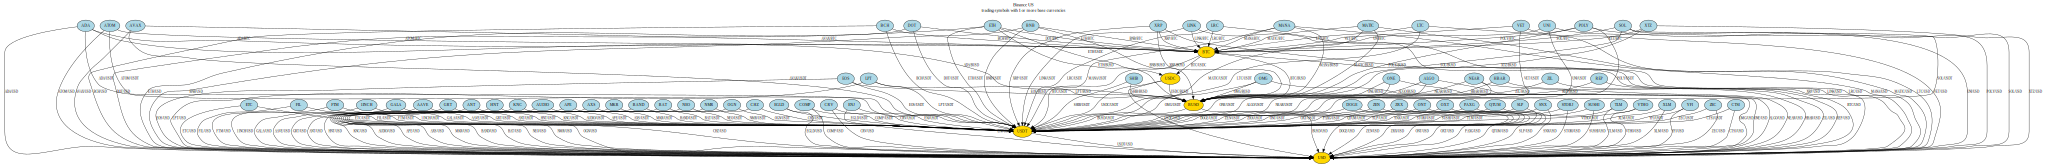

'exchange-symbol-map.png'

In [ ]:
# trim currencies to those that appears as DST, or are N or more SRC

# all currencies trading in N or more base currencies
N = 1

src_nodes = list(src_count[src_count>N].index)
dst_nodes = list(dst_count[dst_count>1].index)
src_dst_nodes = list(set(src_nodes + dst_nodes))

# plot a directed graph from the edges and nodes
label = f"{exch}\ntrading symbols with {N} or more base currencies\n "
dg = Digraph(f"{exch}", 
             graph_attr={'label': label, 'fontsize': '15', 'labelloc': 't'},
             node_attr={'fontsize': '12'},
             edge_attr={'fontsize': '10'})

for node in src_nodes:
    label = f"{node}"
    dg.node(node, label, style='filled', fillcolor='lightblue')

for node in dst_nodes:
    label = f"{node}"
    dg.node(node, label, style='filled', fillcolor='gold')

trade_edges = [[src, dst] for src, dst in src_dst_pairs if (src in src_dst_nodes) and (dst in src_dst_nodes)]
for src, dst in trade_edges:
    symbol = '/'.join([src, dst])
    label = f"{symbol}"
    dg.edge(src, dst, label)

display(dg)
dg.format = "png"
dg.view("exchange-symbol-map")

## Order Book

In [ ]:
trade_symbols = ['/'.join(edge) for edge in trade_edges]

def fetch_order_book(symbol, limit=1, exchange=exchange):
    """return order book data for a specified symbol"""
    start_time = timer()
    result = exchange.fetch_order_book(symbol, limit)
    result["src"], result["dst"] = symbol.split('/')
    result["run_time"] = timer() - start_time
    result["timestamp"] = exchange.milliseconds()
    if result["bids"]:
        result["bid_price"] = result["bids"][0][0]
        result["bid_volume"] = result["bids"][0][1]
    if result["asks"]:
        result["ask_price"] = result["asks"][0][0]
        result["ask_volume"] = result["asks"][0][1]
    return result

# fetch order book data and store in a dictionay
start = timer()
fetched_order_book = {symbol: fetch_order_book(symbol) for symbol in trade_symbols}
run_time = timer() - start
print(f"fetched order book for {len(fetched_order_book)} symbols in {run_time:0.3f} seconds")

# convert to pandas dataframe
order_book = pd.DataFrame(fetched_order_book).T
order_book.drop(columns=["datetime", "symbol", "bids", "asks"], inplace=True)
order_book['timestamp'] = pd.to_datetime(order_book['timestamp'], unit='ms')
order_book

fetched order book for 181 symbols in 13.911 seconds


,timestamp,nonce,src,dst,run_time,bid_price,bid_volume,ask_price,ask_volume
1INCH/USD,2022-03-24 13:35:19.128,13864453,1INCH,USD,0.077452,1.572,943.8,1.576,317.6
1INCH/USDT,2022-03-24 13:35:19.204,9800370,1INCH,USDT,0.075951,1.571,498.5,1.576,317.6
AAVE/USD,2022-03-24 13:35:19.280,169732733,AAVE,USD,0.07585,157.97,10.273,158.26,2.5
AAVE/USDT,2022-03-24 13:35:19.356,53506558,AAVE,USDT,0.075655,157.79,0.19,158.19,4.3537
ADA/BTC,2022-03-24 13:35:19.432,109835428,ADA,BTC,0.076165,0.000027,2335.0,0.000027,2000.0
...,...,...,...,...,...,...,...,...,...
ZEN/USDT,2022-03-24 13:35:32.661,80948986,ZEN,USDT,0.076153,43.885,4.208,43.978,4.439
ZIL/BUSD,2022-03-24 13:35:32.737,58670980,ZIL,BUSD,0.075533,0.04795,4615.2,0.04805,7110.2
ZIL/USD,2022-03-24 13:35:32.812,124331755,ZIL,USD,0.075114,0.0479,152048.3,0.048,15750.0
ZRX/USD,2022-03-24 13:35:32.888,215481183,ZRX,USD,0.07572,0.5682,325.0,0.5701,725.0


## Create directed graph of the order book

In [ ]:
# dictionary of currencies
nodes = dict()
nodes.update({node: {"type": "src"} for node in src_nodes})
nodes.update({node: {"type": "dst"} for node in dst_nodes})

In [ ]:

# dictionary of edges indexed by (src, dst) tuples
#     type: 'bid' or 'ask'
#     conv: 1 unit of src currency produces conv units of dst currency
#     log10_conv: log10 of conv
bids = {(order_book.at[symbol, 'src'], order_book.at[symbol, 'dst']): 
        {'type': 'bid', 
         'conv': order_book.at[symbol, 'bid_price'],
         'log10_conv': np.log10(order_book.at[symbol, 'bid_price']),
         #'volume': order_book.at[symbol, 'bid_volume'],
        }
        for symbol in order_book.index if not np.isnan(order_book.at[symbol, "bid_volume"])
}

asks = {(order_book.at[symbol, 'dst'], order_book.at[symbol, 'src']): 
        {'type': 'ask', 
         'conv': 1.0/order_book.at[symbol, 'ask_price'],
         'log10_conv': np.log10(1.0/order_book.at[symbol, 'ask_price']),
         #'volume': 1.0/order_book.at[symbol, 'ask_volume'],
        }
        for symbol in order_book.index if not np.isnan(order_book.at[symbol, "ask_volume"])
}

edges = dict()
edges.update(bids)
edges.update(asks)

## Graphviz

https://graphviz.readthedocs.io/en/stable/


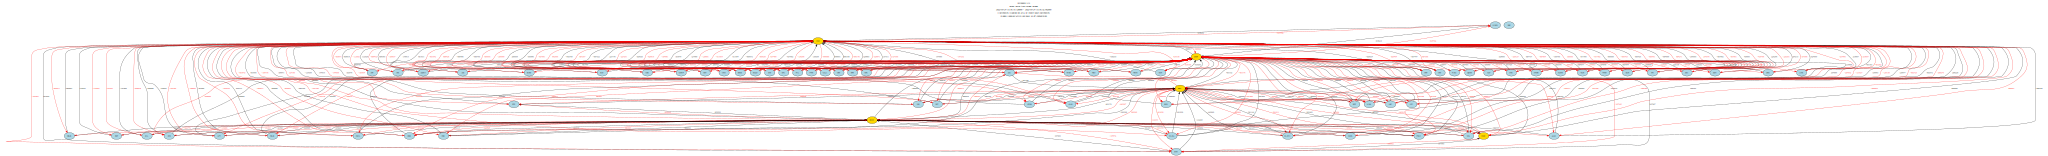

'exchange-dag.png'

In [ ]:
# plot a directed graph from the edges and nodes

timestamp_min = order_book['timestamp'].min()
timestamp_max = order_book['timestamp'].max()

label = f"{exch} \nBest Bid/Ask Order Book\n{timestamp_min} - {timestamp_max}" + \
        "\nCurrencies trading on {N} or more base currencies" + \
        "\nEdges labeled with log base 10 of conversion" + \
        "\n "
dot = Digraph(
        graph_attr={'label': label, 'fontsize': '15', 'labelloc': 't'},
        node_attr={'fontsize': '10'},
        edge_attr={'fontsize': '10'},
    )

for node, prop in nodes.items():
    if prop["type"] == "dst":
        dot.node(node, style='filled', fillcolor='gold')
    else:
        dot.node(node, style='filled', fillcolor='lightblue')

for edge, prop in edges.items():
    src, dst = edge
    log10_conv = prop['log10_conv']
    label=f"{log10_conv:0.5f}"
    if prop["type"] == "bid":
        dot.edge(src, dst, label, color='black', fontcolor='black')
    else:
        dot.edge(src, dst, label, color='red', fontcolor='red')   

display(dot)
dot.format = "png"
dot.view("exchange-dag")

In [ ]:
# split the graph on USD ... 

nodes['USD-SRC'] = {'type': 'src'}
nodes['USD-DST'] = {'type': 'dst'}
nodes.pop('USD', None)

for edge in list(edges.keys()):
    src, dst = edge
    if src == "USD":
        value = edges[edge]
        edges[('USD-SRC', dst)] = value

    elif dst == "USD":
        value = edges[edge]
        edges[(src, 'USD-DST')] = value

for edge in list(edges.keys()):
    src, dst = edge
    if (src == 'USD') or (dst == 'USD'):
        edges.pop(edge)


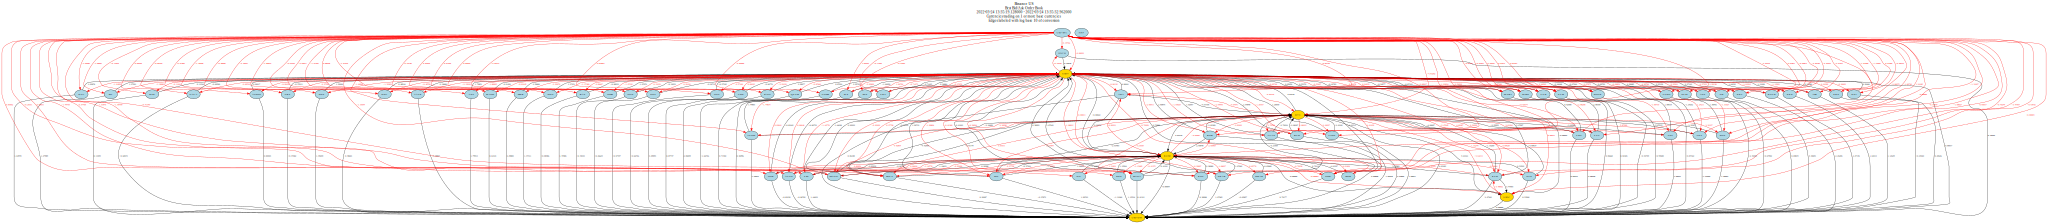

'exchange-dag.png'

In [ ]:


label = f"{exch} \nBest Bid/Ask Order Book\n{timestamp_min} - {timestamp_max}" + \
        f"\nCurrencies trading on {N} or more base currencies" + \
        "\nEdges labeled with log base 10 of conversion" + \
        "\n "
dot = Digraph(
        graph_attr={'label': label, 'fontsize': '15', 'labelloc': 't'},
        node_attr={'fontsize': '10'},
        edge_attr={'fontsize': '10'},
    )

for node, prop in nodes.items():
    if prop["type"] == "dst":
        dot.node(node, style='filled', fillcolor='gold')
    else:
        dot.node(node, style='filled', fillcolor='lightblue')

for edge, prop in edges.items():
    src, dst = edge
    log10_conv = prop['log10_conv']
    label=f"{log10_conv:0.5f}"
    if prop["type"] == "bid":
        dot.edge(src, dst, label, color='black', fontcolor='black')
    else:
        dot.edge(src, dst, label, color='red', fontcolor='red')   

display(dot)
dot.format = "png"
dot.view("exchange-dag")

In [ ]:
import pyomo.environ as pyo

T = 10

m  = pyo.ConcreteModel(f"{exch} arbitrage")

# length of the trading chain
m.T0 = pyo.RangeSet(0, T)
m.T1 = pyo.RangeSet(1, T)

# currency nodes and trading edges
m.NODES = pyo.Set(initialize=nodes.keys())
m.EDGES = pyo.Set(initialize=edges.keys())

# "gain" on each trading edge
@m.Param(m.EDGES)
def a(m, src, dst):
    return 10**edges[(src, dst)]["log10_conv"]

# currency on hand at each node
m.w = pyo.Var(m.NODES, m.T0, domain=pyo.NonNegativeReals)

# amount traded on each edge
m.x = pyo.Var(m.EDGES, m.T1, domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.maximize)
def wealth(m):
    return m.w['USD-DST', T]

# initial assignment of 100 units on a selected currency
@m.Constraint(m.NODES)
def initial(m, node):
    if node == 'USD-SRC':
        return m.w[node, 0] == 1.0
    return m.w[node, 0] == 0.0

@m.Constraint(m.NODES, m.T1)
def no_shorting(m, node, t):
    return m.w[node, t-1] >= sum(m.x[node, dst, t] for src, dst in m.EDGES if src==node)

@m.Constraint(m.NODES, m.T1)
def balances(m, node, t):
    return m.w[node, t] == m.w[node, t-1] - sum(m.x[node, dst, t] for src, dst in m.EDGES if src==node) \
                                          + sum(m.a[src, node]*m.x[src, node, t] for src, dst in m.EDGES if dst==node)

solver = pyo.SolverFactory('cbc')
solver.solve(m)

for node in m.NODES:
    print(f"{node:8s}", end="")
    for t in m.T0:
        print(f" {m.w[node, t]():12.8f}", end="")
    print()

print()

for t in m.T1:
    print(f"t = {t}")
    for src, dst in m.EDGES:
        if m.x[src, dst, t]() > 0:
            print(f"{src:8s} -> {dst:8s}: {m.x[src, dst, t]():0.8f}")
    print()

1INCH      0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
AAVE       0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
ADA        0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
ALGO       0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
ANT        0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
APE        0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000
ATOM       0.00000000   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000  

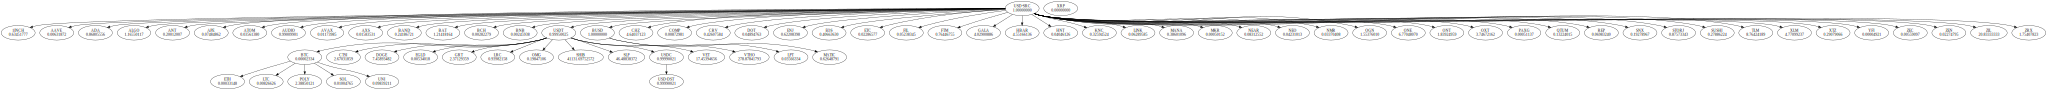

In [ ]:
import math

n = len(nodes)

def visualize(bf):
    adot = Digraph()
    for node in bf.keys():
        w = 10**(-bf[node]["w"])
        if math.isinf(w):
            adot.node(node)
        else:
            adot.node(node, label=f"{node}\n{w:0.8f}")
        if bf[node]['prec'] is not None:
            adot.edge(bf[node]['prec'], node)
    display(adot)

# dictionary of all nodes. 
#   prec: preceding node
#   w: weight

bf = {node: {'prec': None, 'w': float('inf')} for node in nodes}
bf["USD-SRC"]["w"] = 0

for _ in range(n-1):
    for edge in edges.keys():
        src, dst = edge
        w = -edges[edge]["log10_conv"]
        if bf[dst]["w"] > (bf[src]["w"] + w):
            bf[dst]["w"] = bf[src]["w"] + w
            bf[dst]["prec"] = src

visualize(bf)

## Appendix: Asynchronous downloads of order book data

Considerably more development, testing, and validation would be needed to adapt this code to an automated tradign bot to exploit arbitrage opportunities in the crypto-currency markets. One of the time consuming steps is accessing order book data. The following cell is an experiment using the Python `asyncio` library to determine if asynchronous calls to the `ccxt` would provide faster downloads. 

Preliminary testing shows little or no advantage to `asyncio` when working with a single exchange. That may change when the above code is adapted to multi-exchange arbitrage, and therefore this code is retained below for future testing.

In [ ]:
%%script echo skipping

from timeit import default_timer as timer

# asynchronous implementation
import asyncio
import nest_asyncio

my_symbols = ['/'.join(edge) for edge in edges]

async def afetch_order_book(symbol, limit=1, exchange=exchange):
    start_time = timer()
    result = exchange.fetch_order_book(symbol, limit)
    run_time = timer() - start_time
    return result

async def get_data():
    coroutines = [afetch_order_book(symbol) for symbol in my_symbols]
    await asyncio.gather(*coroutines)

start = timer()
nest_asyncio.apply()
asyncio.run(get_data())
run_time = timer() - start

print(run_time)

skipping
